<a href="https://colab.research.google.com/github/sid-chaubs/data-mining-assignment-1/blob/main/DMT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/sid-chaubs/data-mining-assignment-1.git
%cd data-mining-assignment-1/

Cloning into 'data-mining-assignment-1'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.
/content/data-mining-assignment-1/data-mining-assignment-1


Original data shape:  (313, 17)


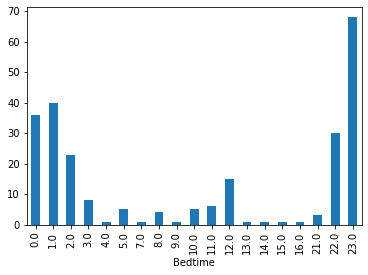

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex

pd.set_option('display.precision', 2)
#read in data
data = pd.read_csv('ODI-2021.csv')
print('Original data shape: ', data.shape)
#sanitize programmes
data['Programme'] = data['What programme are you in?'].apply(lambda s: regex.sub(r'(masters|master|msc|m\s|\sat.*|\suva|\(uva\)|\\|\svu)', '', s.lower()))


#sanitize birthdays
data['Birthday'] = pd.to_datetime(data['When is your birthday (date)?'], errors='coerce')

#normalize course participation data
data['DB course taken'] = data['Have you taken a course on databases?'] == 'ja'
data['Information retrieval course taken'] = data['Have you taken a course on information retrieval?'] == '1'
data['ML course taken'] = data['Have you taken a course on machine learning?'] == 'yes'
data['Statistics course taken'] = data['Have you taken a course on statistics?'] == 'mu'

#sanitize/convert other columns
data['Number of neighbors'] = pd.to_numeric(data['Number of neighbors sitting around you?'], errors='coerce')
data['Stood up'] = data['Did you stand up?'] == 'yes'

data['Stress level'] = pd.to_numeric(data['What is your stress level (0-100)?'], errors='coerce')
data['Stress level'] = list(map(lambda d: min(100, d), data['Stress level']))
data['Competition reward'] = pd.to_numeric(data['You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? '], errors='coerce')
data['Random number'] = pd.to_numeric(data['Give a random number'], errors='coerce')

match_single_hours = r'(^[0-9]+)\s*(am|pm|$)$'
match_dots = r'([0-9]+)\.([0-9]+)'
#sanitize bedtime
data['Bedtime'] = pd.to_datetime(list(map(lambda dt: regex.sub(match_single_hours, r'\1:00 \2', dt), 
                                          map(lambda dt: regex.sub(match_dots, r'\1:\2', dt), data['Time you went to be Yesterday']))), 
                                 errors='coerce')
data['Bedtime'].groupby(data['Bedtime'].dt.hour).count().plot(kind='bar')

In [87]:
#different regexs for matching possible observed programme names 
match_superfluous = r'(masters|master|msc|m\s|\sat.*|\suva|\(uva\)|\\|\svu)'
match_cs = r'.*(^cs|\scs|computer science|computational science).*'
match_ai = r'.*(^ai|\sai|artificial intelligence).*'
match_bio = r'.*(bioinformatics and systems biology|bioinformatics & systems biology).*'
match_qrm = r'.*(qrm|quantative risk management|quantitative risk management).*'
match_ba = r'.*(^ba|\sba|business analytics)'
match_eor = r'.*(^eor|^e&or|^or|econometrics and operation.*)'
match_eds = r'.*(^eds|econometrics and data science.*)'
match_ec = r'.*(econometrics)'
match_ft = r'.*(^ft|fintech|finance & technology)'

#zip the matching regexes and corresponding substitutions together
regsubs = zip([match_superfluous, match_cs, match_ai, match_bio, match_qrm, match_ba, match_eor, match_eds, match_ec, match_ft],
              ['', 'Computer Science', 'Artificial Intelligence', 'Bioinformatics and Systems Biology', 'Quantitative Risk Management',
               'Business Analytics', 'Econometrics and Operations Research', 'Econometrics and Data Science', 'Econometrics', 'Finane and Technology'])

def regex_to_sub(re, substr):
  '''Helper function for creating an anonymous substitution function with regex.'''
  return lambda s: regex.sub(re, substr, s)

#convert to lowercase, substitute course names, remove leading/trailing spaces and capitalize everything left
regfuncs = [lambda s: s.lower()]\
  + [regex_to_sub(re, s) for re, s in regsubs]\
  + [str.strip, lambda s: s[0].upper() + s[1:]] 

def chain_sanitize(data, funcs):
  '''Apply a list of functions to data in sequence and return the result.'''
  res = data
  for f in funcs:
    res = res.apply(f)
  return res

list(chain_sanitize(data['What programme are you in?'], regfuncs))

['Tax law - tax and technology',
 'Artificial Intelligence',
 'Dmt',
 'Computer Science',
 'Artificial Intelligence',
 'Systesecurity',
 'Quantitative Risk Management',
 'Computer Science',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Computer Science',
 'Artificial Intelligence',
 'Big data engineering',
 'Bioinformatics and Systems Biology',
 'Human language technology',
 'Artificial Intelligence',
 'Computer Science',
 'Artificial Intelligence',
 'Quantitative Risk Management',
 'Business Analytics',
 'Artificial Intelligence',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Artificial Intelligence',
 'Linguistics: text mining',
 'Bioinformatics and Systems Biology',
 'Business Analytics',
 'Bioinformatics and Systems Biology',
 'Computer Science',
 'Python',
 'Econometrics and Operations Research',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Rma human language technology',
 'Human language technology (research 

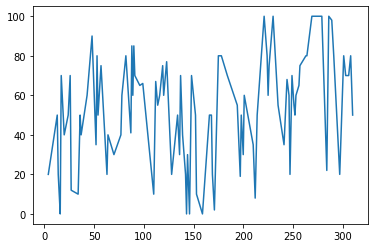

In [52]:
data.loc[(data['What is your gender?'] == 'female')]['Stress level'].plot()

In [11]:
gendermeans = data.groupby(['What is your gender?']).mean()

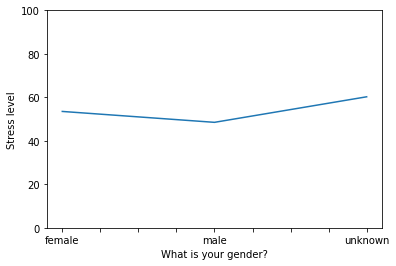

In [12]:
gendermeans['Stress level'].plot(ylabel='Stress level', ylim=(0,100))

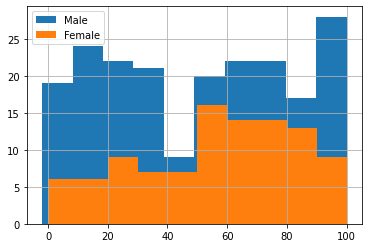

In [13]:
data.loc[data['What is your gender?']=='male']['Stress level'].hist()
data.loc[data['What is your gender?']=='female']['Stress level'].hist()
plt.legend(['Male', 'Female'])

In [21]:
list(data['What programme are you in?'])

['Master Tax Law - Tax and Technology',
 'AI',
 'DMT',
 'CS',
 'AI',
 'system security',
 'Quantitative Risk Management',
 'Computational Science',
 'AI',
 'AI',
 'Computational Science',
 'AI',
 'big data engineering ',
 'MSc in Bioinformatics and Systems Biology',
 'Human Language Technology',
 'Artificial Intelligence',
 'computational science',
 'MSc Artificial Intelligence',
 'QRM',
 'Master Business Analytics',
 'Msc Artificial Intelligence',
 'Computational Science',
 'cs',
 'Computational Science',
 'CS',
 'AI Masters',
 'Linguistics: Text Mining',
 'Bioinformatics and Systems Biology',
 'BA',
 'Master Bioinformatics & Systems Biology',
 'Master in Computational Science',
 'Python',
 'Msc Econometrics and Operations Research',
 'Computational science',
 'Computational Science',
 'Computational Science',
 'rMA Human Language Technology',
 'Human Language Technology (Research Master Linguistics)',
 'Econometrics and Operations Research',
 'Econometrics & Data Science',
 'MSc Arti

In [84]:
a = [1,2]\
  + [3,4]

In [58]:
print(*zip([1,2,3], [4,5,6]))

(1, 4) (2, 5) (3, 6)


In [16]:
list(data['What programme are you in?'].apply(lambda s: regex.sub(r'\W*(artificial intelligence)', r'AI', s.lower())))

['master tax law - tax and technology',
 'ai',
 'dmt',
 'cs',
 'ai',
 'system security',
 'quantitative risk management',
 'computational science',
 'ai',
 'ai',
 'computational science',
 'ai',
 'big data engineering ',
 'msc in bioinformatics and systems biology',
 'human language technology',
 'AI',
 'computational science',
 'mscAI',
 'qrm',
 'master business analytics',
 'mscAI',
 'computational science',
 'cs',
 'computational science',
 'cs',
 'ai masters',
 'linguistics: text mining',
 'bioinformatics and systems biology',
 'ba',
 'master bioinformatics & systems biology',
 'master in computational science',
 'python',
 'msc econometrics and operations research',
 'computational science',
 'computational science',
 'computational science',
 'rma human language technology',
 'human language technology (research master linguistics)',
 'econometrics and operations research',
 'econometrics & data science',
 'mscAI',
 'econometrics and operation research',
 'econometrics & operatio

In [54]:
pd.duplicate()

AttributeError: ignored